In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

from pyproj import Geod
from shapely.geometry import MultiPoint
from shapely.geometry import Point, LineString, Polygon
import shapely.wkt

from shapely.geometry import shape

import contextily as ctx

import geojson

In [6]:
# load camps
df = pd.read_csv('./resources/poi.csv', sep=';')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           30 non-null     object 
 1   Camp Type      30 non-null     object 
 2   Longitude (E)  30 non-null     float64
 3   Latitude (S)   30 non-null     float64
 4   geometry       30 non-null     object 
 5   RouteInfoList  30 non-null     object 
dtypes: float64(2), object(4)
memory usage: 1.5+ KB


In [16]:
from geojson import Point, Feature, FeatureCollection, dump
import json

features = []


for i, row in df.iterrows():

    props = {
        'name': row['Name'],
        'type': row['Camp Type'],
        'routeListStr': row['RouteInfoList'],
        'routeList': json.loads(row['RouteInfoList'])
    }

    ft = Feature(geometry=Point((row['Longitude (E)'], row['Latitude (S)'])), properties=props)
    features.append(ft)



fc = FeatureCollection(features)
jsonString = geojson.dumps(fc)


with open("resources/poi.geojson", "w") as text_file:
    text_file.write(jsonString)



In [14]:
jsonString

'{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Point", "coordinates": [31.20233, -23.23406]}, "properties": {"name": "Bateleur", "type": "Bushveld camp", "routeList": {"RouteInfoList": [{"Origin": {"X": 31.20233, "Y": -23.23406, "Latitude": -23.23406, "Longitude": 31.20233, "PositionArray": [31.20233, -23.23406], "Bearing": 0}, "Destination": {"X": 31.45122, "Y": -25.42001, "Latitude": -25.42001, "Longitude": 31.45122, "PositionArray": [31.45122, -25.42001], "Bearing": 0}, "Duration": 25060.86322200001, "Length": 339695.7010000001}, {"Origin": {"X": 31.20233, "Y": -23.23406, "Latitude": -23.23406, "Longitude": 31.20233, "PositionArray": [31.20233, -23.23406], "Bearing": 0}, "Destination": {"X": 31.69903, "Y": -25.32122, "Latitude": -25.32122, "Longitude": 31.69903, "PositionArray": [31.69903, -25.32122], "Bearing": 0}, "Duration": 23337.271410000005, "Length": 312954.03099999996}, {"Origin": {"X": 31.20233, "Y": -23.23406, "Latitude": -23.23406, "

In [5]:
df.to_csv('camp_waypoints.csv', index=False)

In [6]:
gates = [
    {
        'name': 'Crocodile Bridge Gate',
        'lng': 31.893563,
        'lat':-25.358438,
    },

    {
        'name': 'Kruger Gate',
        'lng':31.484812,
        'lat':-24.980938,
    },
    {
        'name': 'Malelane Gate',
        'lng': 31.532321,
        'lat':-25.462187,
    },

    {
        'name': 'Numbi Gate',
        'lng':31.198188,
        'lat':-25.155313,
    },

    {
        'name': 'Orpen Gate',
        'lng': 31.390833,
        'lat': -24.475833,
    },

    {
        'name': 'Pafuri Gate',
        'lng': 31.041389,
        'lat': -22.400278,
    },

    {
        'name': 'Phabeni Gate',
        'lng': 31.240647,
        'lat':-25.024690,
    },
    {
        'name': 'Phalaborwa Gate',
        'lng': 31.165687,
        'lat': -23.945687,
    },
    {
        'name': 'Punda Maria Gate',
        'lng': 31.010438,
        'lat': -22.737313,
    },
]

df_gates = pd.DataFrame(gates)

In [7]:
df_gates.to_csv('gates.csv', index=False)

### read in routes

In [8]:
with open('resources/knp_graph.geojson') as f:
    routes = geojson.load(f)

edges = []

for feature in routes['features']:

    if feature['geometry']['type'] == 'Point':
        continue

    if feature['geometry']['type'] == 'LineString':
        edges.append({
            'geometry': shape(feature['geometry'])
        })
        #edges.append({feature['geometry'])

    else:
        print(feature['geometry']['type'])

edges_df = pd.DataFrame(edges)

edges_gdf = geopandas.GeoDataFrame(
    edges_df, geometry=edges_df['geometry'])


In [2]:
#knp graph opnly roads
from geojson import Point, Feature, FeatureCollection, dump


with open('resources/knp_graph.geojson') as f:
    routes = geojson.load(f)

features = []

for feature in routes['features']:

    if feature['geometry']['type'] == 'Point':
        continue

    if feature['geometry']['type'] == 'LineString':
        features.append(feature)

feature_collection = FeatureCollection(features)

with open('knp_graph_streets.geojson', 'w') as f:
    dump(feature_collection, f)


## Visualiziation of availbale points

In [9]:
camps_df = df[df['Camp Type'] == 'Rest camp']

gates_gdf = geopandas.GeoDataFrame(
    df_gates, geometry=geopandas.points_from_xy(df_gates['lng'], df_gates['lat']))

camps_gdf = geopandas.GeoDataFrame(
    camps_df, geometry=camps_df['geometry'])

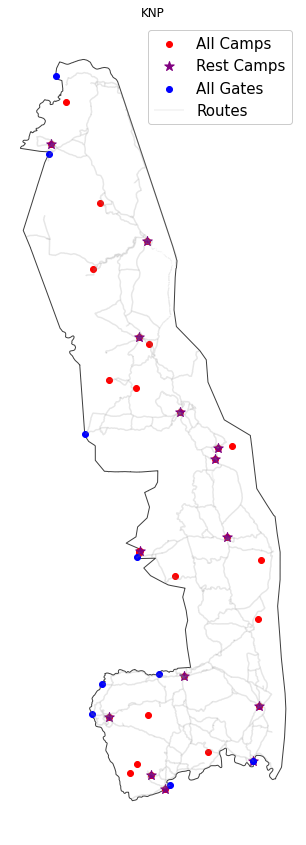

In [10]:
map_df = geopandas.read_file('knp.geojson')

fig, ax = plt.subplots(figsize = (15, 15))

ax.set(title="KNP")
map_df.plot(ax = ax, alpha = 0.75, facecolor='none', edgecolor='black')

gdf.plot(ax=ax, color='red', label="All Camps")

camps_gdf.plot(ax=ax, color='purple', marker='*', markersize=100, label="Rest Camps")

gates_gdf.plot(ax=ax, color='blue', label="All Gates")

edges_gdf.plot(ax=ax, color='gray', alpha=0.1, label="Routes")



ax.set_axis_off() # no axis needed in mercator?
plt.legend(framealpha=1, prop={'size':15})
plt.show()

# Generate scheduler CSV files


To create a reduced (testing) set of points, set the `fecnce_wkt` variable to a `POLYGON()` WKT-string. Only points within the polygon will be used for generating the scheduler CSV files.


In [11]:
# fence around lower southern part of KNP
fence_wkt = "POLYGON ((31.00616455078125 -25.579607925105687, 32.20092773437499 -25.579607925105687, 32.20092773437499 -24.9337667593888, 31.00616455078125 -24.9337667593888, 31.00616455078125 -25.579607925105687))"
fence = shapely.wkt.loads(fence_wkt)

fence_gdf = geopandas.GeoDataFrame([[fence]],
            columns=['geometry'],
            geometry='geometry')


# disable fencing by setting fence = False
#fence = False


## Gate -> Camp: commuters

Scheduler CSV file for commuters:

- only `Rest camp`s are targets
- distance between gate and camp musst be >= 2km and < 90km
  - min distance to counter act camp directly at gate
  - 90km upper limit to allow for a "reasonable" commuting distance/duration
- inside fence (if set)


In [14]:
# output configuration

# how long should a commuter work at it's camp? (in minutes)
work_duration = 7 * 60

scheduler_rows = []
connections = []

for gate in gates:
    source = Point(gate['lng'], gate['lat'])
    target_list = []

    if fence is not False and not fence.contains(source):
        continue

    for target in camps_df['geometry'].tolist():
        line_string = LineString([source, target])
        geod = Geod(ellps="WGS84")
        distance = geod.geometry_length(line_string) # in meters

        if fence is not False and not fence.contains(target):
            continue

        # check if gate and camp are identical
        if distance < 2000:
            #print("distance from {} to x  to short ({}).".format(gate['name'], line_string.wkt))
            continue

        if distance > (90*1000):
            #print("distance from {} to x  to long ({}).".format(gate['name'], line_string.wkt))
            continue

        if source is not target:
            target_list.append(target)
            connections.append({'wkt': line_string.wkt, 'geometry': line_string})

    mp = MultiPoint(target_list)


    scheduler_rows.append({
        'startTime': '6:00',
        'endTime':   '8:00',
        'spawningIntervalInMinutes': 20,
        'spawningAmount': 1,
        'gateName': gate['name'],
        'workDuration': work_duration,
        'source': source.wkt,
        'destination': mp.wkt
    })

    scheduler_rows.append({
        'startTime': '8:00',
        'endTime':   '12:00',
        'spawningIntervalInMinutes': 45,
        'spawningAmount': 1,
        'gateName': gate['name'],
        'workDuration': work_duration - 3*60,
        'source': source.wkt,
        'destination': mp.wkt
    })

scheduler_df = pd.DataFrame(scheduler_rows)
scheduler_df.to_csv('CommScheduler.csv', index=False)

connections_df = pd.DataFrame(connections)
connections_df.to_csv('connections.csv', index=False)

connections_gdf = geopandas.GeoDataFrame(
    connections_df, geometry=(connections_df['geometry']))

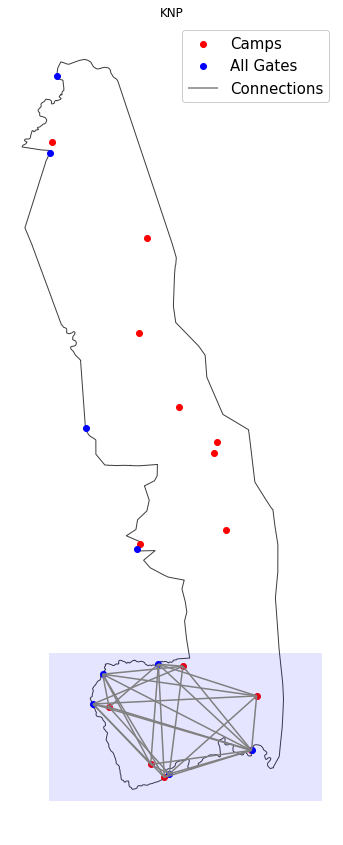

In [55]:
map_df = geopandas.read_file('knp.geojson')

fig, ax = plt.subplots(figsize = (15, 15))

ax.set(title="KNP")
map_df.plot(ax = ax, alpha = 0.75, facecolor='none', edgecolor='black')

camps_gdf.plot(ax=ax, color='red', label="Camps")
gates_gdf.plot(ax=ax, color='blue', label="All Gates")

connections_gdf.plot(ax=ax, color='gray', label="Connections")

if fence:
    fence_gdf.plot(ax=ax, color='blue', alpha=0.1, label="Fence")

ax.set_axis_off() # no axis needed in mercator?
plt.legend(framealpha=1, prop={'size':15})
plt.show()

# Camp -> Camp

In [15]:
scheduler_rows = []
connections = []

for source in camps_df['geometry'].tolist():

    target_list = []

    if not fence.contains(source):
        continue

    for target in camps_df['geometry'].tolist():

        line_string = LineString([source, target])
        geod = Geod(ellps="WGS84")
        distance = geod.geometry_length(line_string) # in meters

        if not fence.contains(target):
            continue

        if distance > (200*1000):
            #print("distance from {} to x  to long ({}).".format(gate['name'], line_string.wkt))
            continue

        if source is not target:
            target_list.append(target)
            connections.append({'wkt': line_string.wkt})

    mp = MultiPoint(target_list)

    scheduler_rows.append({
        'startTime': '6:00',
        'endTime': '12:00',
        'spawningIntervalInMinutes': 30,
        'spawningAmount': 1,
        'source': source.wkt,
        'destination': mp.wkt
    })


scheduler_df = pd.DataFrame(scheduler_rows)
scheduler_df.to_csv('Camp2CampScheduler.csv', index=False)